In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
join = os.path.join
from skimage import io
from tqdm import tqdm
import torch
from torch.utils.data import Dataset, DataLoader
import monai
from monai.networks import one_hot
from segment_anything import SamPredictor, sam_model_registry
from segment_anything.utils.transforms import ResizeLongestSide
from utils.SurfaceDice import compute_dice_coefficient
from skimage import io, transform
# set seeds
torch.manual_seed(2023)
np.random.seed(2023)

In [2]:
data_tr_path = '/gpfs/data/luilab/karthik/MultiOrganDemo_2D/train/'
embed_tr_path = join(data_tr_path, 'img_embed')
os.makedirs(embed_tr_path, exist_ok=True)
# the dataset contains 13 organs. https://flare22.grand-challenge.org/
# Please select the organ you want to segment by setting the label_id.
label_id = 1 # liver
model_type = 'vit_b'
checkpoint = '/gpfs/home/kn2347/MedSAM/medsam_vit_b.pth'
device = 'cuda:0'
sam_model = sam_model_registry[model_type](checkpoint=checkpoint).to(device)

In [4]:
# pre-compute image image embedding
names = sorted(os.listdir(join(data_tr_path, 'images')))
for name in tqdm(names):
    image_data = io.imread(join(data_tr_path, 'images', name))
    if image_data.shape[-1]>3 and len(image_data.shape)==3:
        image_data = image_data[:,:,:3]
    if len(image_data.shape)==2:
        image_data = np.repeat(image_data[:,:,None], 3, axis=-1)
    
    

    # resize
    sam_transform = ResizeLongestSide(sam_model.image_encoder.img_size)
    resize_img = sam_transform.apply_image(image_data)
    resize_img_tensor = torch.as_tensor(resize_img.transpose(2, 0, 1)).to(device)
    
    #%% image preprocessing and model inference
    #img_1024 = transform.resize(image_data, (1024, 1024), order=3, preserve_range=True, anti_aliasing=True).astype(np.uint8)
    
    
    resize_img_tensor = (resize_img_tensor - resize_img_tensor.min()) / torch.clip(
        resize_img_tensor.max() - resize_img_tensor.min(), min=1e-8, max=None
    )  
    input_tensor = resize_img_tensor[None, :, : ,:] # (1x3xHxW)
    #box_np = np.array([[95,255, 190, 350]])
    # transfer box_np t0 1024x1024 scale
    #box_1024 = box_np / np.array([W, H, W, H]) * 1024
    with torch.no_grad():
        embedding = sam_model.image_encoder(input_tensor)
        # save the image embedding
        np.save(join(embed_tr_path, name.split('.png')[0]+'.npy'), embedding.cpu().numpy()[0])

    

100%|██████████| 3704/3704 [09:32<00:00,  6.47it/s]


In [6]:
#%% create a dataset class to load npz data and return back image embeddings and ground truth
class DatasetPngNPy(Dataset): 
    def __init__(self, data_root, label_id=1):
        self.data_root = data_root
        self.files = sorted(os.listdir(join(self.data_root, 'labels'))) 
        self.label_id = label_id
    
    def __len__(self):
        return len(self.files)

    def __getitem__(self, index):
        img_embed = np.load(join(self.data_root, 'img_embed', self.files[index].split('.')[0]+'.npy'))
        gt2D = io.imread(join(self.data_root, 'labels', self.files[index]))
        gt2D = (gt2D==self.label_id).astype(np.uint8)

        # convert img embedding, mask, bounding box to torch tensor
        return torch.tensor(img_embed).float(), torch.tensor(gt2D[None, :,:]).long()

In [ ]:
# %% test dataset class and dataloader
demo_dataset = DatasetPngNPy(data_tr_path, label_id=label_id)
demo_dataloader = DataLoader(demo_dataset, batch_size=8, shuffle=True)
for img_embed, gt in demo_dataloader:
    # img_embed: (B, 256, 64, 64), gt2D: (B, C, 256, 256)
    print(f"{img_embed.shape=}, {gt.shape=}")
    plt.imshow(gt[5,0,:,:].numpy())
    plt.axis('off')
    break

In [8]:
# %% set up model for fine-tuning 
# train data path
work_dir = '/gpfs/data/luilab/karthik/MultiOrganDemo_2D/work_dir'
task_name = 'AutoSegDemo2D'
# prepare SAM model
model_save_path = join(work_dir, task_name)
os.makedirs(model_save_path, exist_ok=True)
# Set up the optimizer, hyperparameter tuning will improve performance here
optimizer = torch.optim.Adam(sam_model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)
seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

In [ ]:
#%% train
num_epochs = 100
losses = []
best_loss = 1e10
train_dataset = DatasetPngNPy(data_tr_path, label_id=label_id)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
sam_model.train()
for epoch in range(num_epochs):
    epoch_loss = 0
    # train
    for step, (image_embedding, gt) in enumerate(tqdm(train_dataloader)):
        # do not compute gradients for image encoder and prompt encoder
        with torch.no_grad():
            B,_, H, W = gt.shape
            # set the bbox as the image size for fully automatic segmentation
            boxes = torch.from_numpy(np.array([[0,0,W,H]]*B)).float().to(device)
            sparse_embeddings, dense_embeddings = sam_model.prompt_encoder(
                points=None,
                boxes=boxes[:, None, :],
                masks=None,
            )
        # predicted masks
        mask_predictions, _ = sam_model.mask_decoder(
            image_embeddings=image_embedding.to(device), # (B, 256, 64, 64)
            image_pe=sam_model.prompt_encoder.get_dense_pe(), # (1, 256, 64, 64)
            sparse_prompt_embeddings=sparse_embeddings, # (B, 2, 256)
            dense_prompt_embeddings=dense_embeddings, # (B, 256, 64, 64)
            multimask_output=False,
          )

        loss = seg_loss(mask_predictions, gt.to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    epoch_loss /= step
    losses.append(epoch_loss)
    print(f'EPOCH: {epoch}, Loss: {epoch_loss}')
    # save the latest model checkpoint
    torch.save(sam_model.state_dict(), join(model_save_path, 'sam_model_latest.pth'))
    # save the best model
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        torch.save(sam_model.state_dict(), join(model_save_path, 'sam_model_best.pth'))

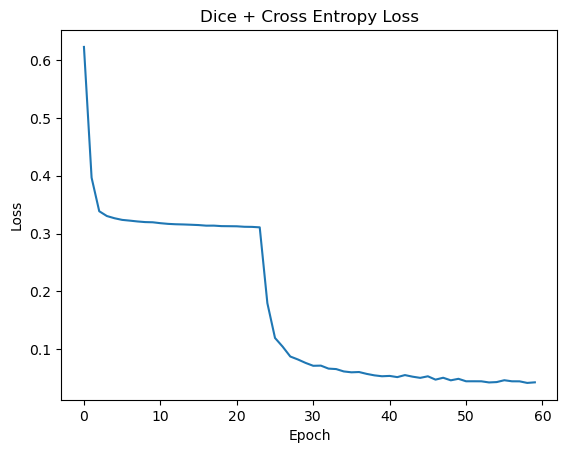

In [12]:
# plot loss
plt.plot(losses)
plt.title('Dice + Cross Entropy Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show() # comment this line if you are running on a server
plt.savefig(join(model_save_path, 'train_loss.png'))
plt.close()

In [19]:
#%% compare the segmentation results between the original SAM model and the fine-tuned model
# load the original SAM model
ori_sam_model = sam_model_registry[model_type](checkpoint=checkpoint).to(device)
ori_sam_predictor = SamPredictor(ori_sam_model)

ts_img_path = '/gpfs/data/luilab/karthik/MultiOrganDemo_2D/test/images'
ts_gt_path = '/gpfs/data/luilab/karthik/MultiOrganDemo_2D/test/labels'
test_names = sorted(os.listdir(ts_img_path))
test_names = [name for name in test_names if np.sum(io.imread(join(ts_gt_path, name))==label_id)>0]
# random select a test case
img_idx = np.random.randint(len(test_names))
image_data = io.imread(join(ts_img_path, test_names[img_idx]))
if image_data.shape[-1]>3 and len(image_data.shape)==3:
    image_data = image_data[:,:,:3]
if len(image_data.shape)==2:
    image_data = np.repeat(image_data[:,:,None], 3, axis=-1)
# read ground truth (gt should have the same name as the image) and simulate a bounding box
gt_data = io.imread(join(ts_gt_path, test_names[img_idx]))
gt_data = (gt_data==label_id).astype(np.uint8)
H, W = gt_data.shape

# predict the segmentation mask using the original SAM model
ori_sam_predictor.set_image(image_data)
ori_sam_seg, _, _ = ori_sam_predictor.predict(point_coords=None, box=np.array([0,0,H,W]), multimask_output=False)

In [20]:
# predict the segmentation mask using the fine-tuned model
# resize image to 3*1024*1024


# resize
sam_transform = ResizeLongestSide(sam_model.image_encoder.img_size)
resize_img = sam_transform.apply_image(image_data)
resize_img_tensor = torch.as_tensor(resize_img.transpose(2, 0, 1)).to(device)

#%% image preprocessing and model inference
#img_1024 = transform.resize(image_data, (1024, 1024), order=3, preserve_range=True, anti_aliasing=True).astype(np.uint8)


resize_img_tensor = (resize_img_tensor - resize_img_tensor.min()) / torch.clip(
    resize_img_tensor.max() - resize_img_tensor.min(), min=1e-8, max=None
)  
input_tensor = resize_img_tensor[None, :, : ,:] # (1x3xHxW)
#box_np = np.array([[95,255, 190, 350]])
# transfer box_np t0 1024x1024 scale
#box_1024 = box_np / np.array([W, H, W, H]) * 1024




with torch.no_grad():
    # pre-compute the image embedding
    ts_img_embedding = sam_model.image_encoder(input_tensor)
    box_torch =torch.from_numpy(np.array([[0,0,W,H]])).float().to(device)
    if len(box_torch.shape) == 2:
        box_torch = box_torch[:, None, :] # (B, 4) -> (B, 1, 4)
    
    sparse_embeddings, dense_embeddings = sam_model.prompt_encoder(
        points=None,
        boxes=box_torch,
        masks=None,
    )
    medsam_seg_prob, _ = sam_model.mask_decoder(
        image_embeddings=ts_img_embedding.to(device), # (B, 256, 64, 64)
        image_pe=sam_model.prompt_encoder.get_dense_pe(), # (1, 256, 64, 64)
        sparse_prompt_embeddings=sparse_embeddings, # (B, 2, 256)
        dense_prompt_embeddings=dense_embeddings, # (B, 256, 64, 64)
        multimask_output=False,
        )
    medsam_seg_prob = torch.sigmoid(medsam_seg_prob)
    # convert soft mask to hard mask
    medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
    medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)

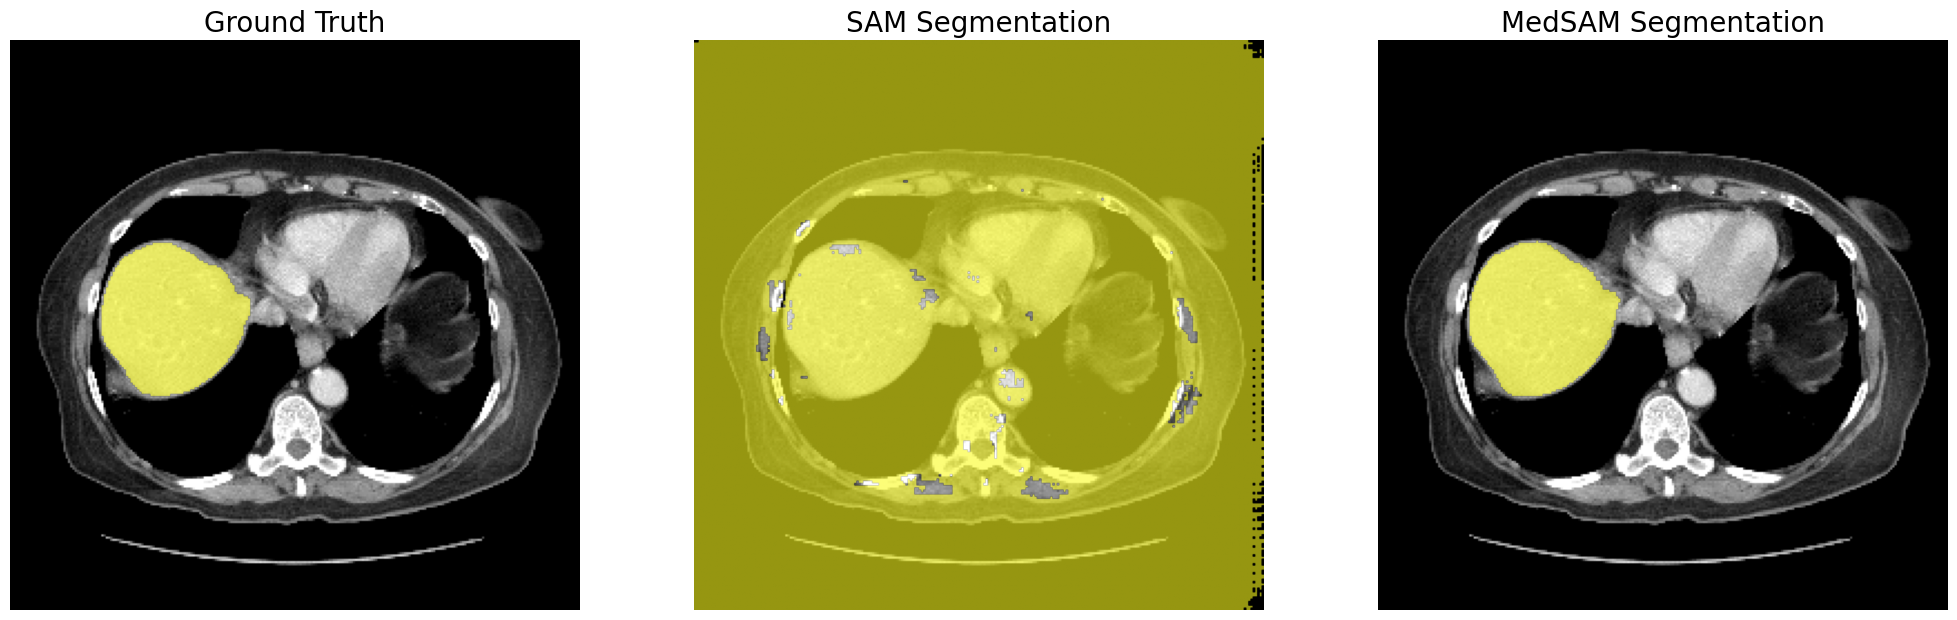

In [21]:
#%% visualize the segmentation results of the middle slice
# visualization functions
# source: https://github.com/facebookresearch/segment-anything/blob/main/notebooks/predictor_example.ipynb
# change color to avoid red and green
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([251/255, 252/255, 30/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='blue', facecolor=(0,0,0,0), lw=2))    

_, axs = plt.subplots(1, 3, figsize=(25, 25))
axs[0].imshow(image_data)
show_mask(gt_data>0, axs[0])
axs[0].set_title('Ground Truth', fontsize=20)
axs[0].axis('off')

axs[1].imshow(image_data)
show_mask(ori_sam_seg, axs[1])
axs[1].set_title('SAM Segmentation', fontsize=20)
axs[1].axis('off')

axs[2].imshow(image_data)
show_mask(medsam_seg, axs[2])
axs[2].set_title('MedSAM Segmentation', fontsize=20)
axs[2].axis('off')
plt.show()  
plt.subplots_adjust(wspace=0.01, hspace=0)
# save plot
# plt.savefig(join(model_save_path, test_npzs[npz_idx].split('.npz')[0] + str(img_id).zfill(3) + '.png'), bbox_inches='tight', dpi=300)
plt.close()